# 2D Burger's LaSDI-LS Example

In [1]:
import numpy as np
import numpy.linalg as LA
import matplotlib.pyplot as plt
from itertools import product
import sys,time
import os
import pickle
sys.path.append("..") # Adds higher directory to python modules path.
from LaSDI import LaSDI

import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.pyplot.title(r'ABC123 vs $\mathrm{ABC123}^{123}$')
plt.rcParams['font.size'] = 28
plt.rcParams['axes.linewidth'] = 2
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False

### Import simulation data, parameters, etc.

In [2]:
LS_dim = 3
snapshot_file = './data/snapshot_git.p'
FOM_file = './data/FOM.p' 

In [3]:
# Given parameters
nx = 60
ny = 60
m = (ny-2)*(nx-2) # 3364
nt = 1500
tstop = 2
dt = tstop/nt
t = np.linspace(0,tstop,nt)

In [4]:
snapshot = pickle.load(open(snapshot_file, 'rb'))

snapshot_u = snapshot['u'].reshape(-1,nx*ny).astype('float32')
snapshot_v = snapshot['v'].reshape(-1,nx*ny).astype('float32')
ndata = snapshot_u.shape[0]

nset = round(ndata/(nt+1))

# remove BC
multi_index_i,multi_index_j=np.meshgrid(np.arange(nx),np.arange(ny),indexing='xy')
full_multi_index=(multi_index_j.flatten(),multi_index_i.flatten())
free_multi_index=(multi_index_j[1:-1,1:-1].flatten(),multi_index_i[1:-1,1:-1].flatten())

dims=(ny,nx)
full_raveled_indicies=np.ravel_multi_index(full_multi_index,dims)
free_raveled_indicies=np.ravel_multi_index(free_multi_index,dims)

orig_data_u = snapshot_u[:,free_raveled_indicies]
orig_data_v = snapshot_v[:,free_raveled_indicies]

[xv,yv]=np.meshgrid(np.linspace(-3,3,nx),np.linspace(-3,3,ny),indexing='xy')
x=xv.flatten()
y=yv.flatten()

x_free=x[free_raveled_indicies]
y_free=y[free_raveled_indicies]

### Find POD for both $U$ and $V$

In [5]:
u,s,vh = LA.svd(orig_data_u.T)
sv_mass = np.cumsum(s)
sv_count = 5# [i for i,ss in enumerate(sv_mass) if ss/sv_mass[-1]>.99][0]+1
# s[sv_count:] = 0
print(sv_count, sv_mass[:sv_count]/sv_mass[-1])
phi_u = u[:,:sv_count]


u,s,vh = LA.svd(orig_data_v.T)
sv_mass = np.cumsum(s)
sv_count = 5# [i for i,ss in enumerate(sv_mass) if ss/sv_mass[-1]>.99][0]+1
# s[sv_count:] = 0
print(sv_count, sv_mass[:sv_count]/sv_mass[-1])
phi_v = u[:,:sv_count]

5 [0.43356204 0.5966159  0.6871546  0.74487233 0.78594476]
5 [0.43356204 0.5966159  0.6871546  0.74487233 0.78594476]


### Visualize Singular Value Decay

(1e-05, 10000)

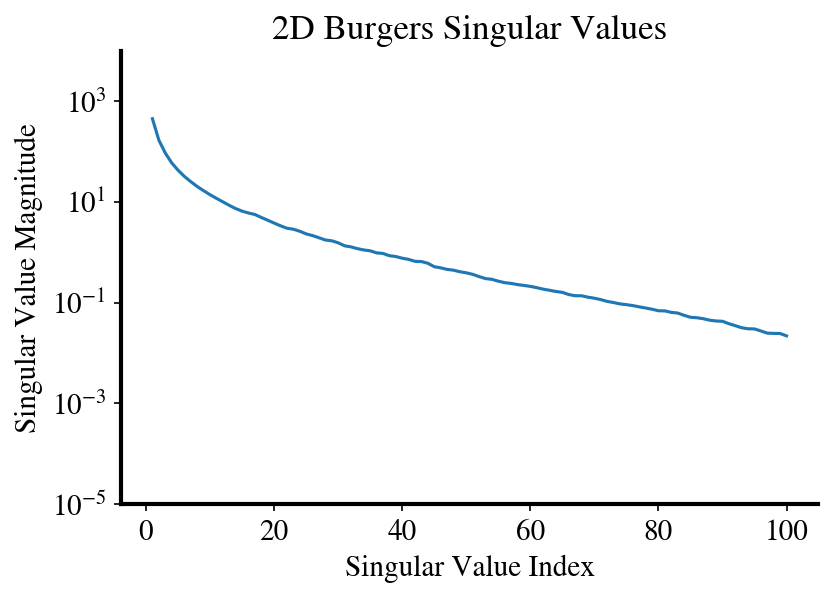

In [26]:
fig, ax = plt.subplots(1,1)
ax.set_title('2D Burgers Singular Values')
ax.set_xlabel('Singular Value Index')
ax.set_ylabel('Singular Value Magnitude')
cut_off = 100
ax.plot(np.arange(1,cut_off+1),s[:cut_off])
ax.set_yscale('log')
ax.set_ylim(1e-5,10000)

## Generate Latent-Space Trajectories from Training Data

In [7]:
latent_space_SS_u = []
latent_space_SS_v = []

for foo in range(nset):
    latent_space_u = np.matmul(phi_u.T, orig_data_u[foo*(nt+1):(foo+1)*(nt+1)].T).T
    latent_space_v = np.matmul(phi_v.T, orig_data_v[foo*(nt+1):(foo+1)*(nt+1)].T).T
    latent_space_SS_u.append(latent_space_u)
    latent_space_SS_v.append(latent_space_v)

In [8]:
amp_arr = [.9,1.1]
width_arr = [.9,1.1]
P = list(product(amp_arr, width_arr))
P = np.array(P)

### Generate LaSDI-LS Models for $U$ and $V$

Dynamical System for U
(x0)' = -0.174 1 + -0.607 x0 + 0.895 x1 + 0.918 x2 + -0.439 x3 + -0.092 x4
(x1)' = -0.344 1 + -1.232 x0 + -0.707 x1 + 1.489 x2 + -1.738 x3 + -0.872 x4
(x2)' = 0.018 1 + -0.290 x0 + -2.201 x1 + -1.173 x2 + -2.833 x3 + -1.935 x4
(x3)' = -0.020 1 + 0.219 x0 + 0.996 x1 + 3.189 x2 + -1.168 x3 + 3.982 x4
(x4)' = -0.238 1 + -0.232 x0 + 1.038 x1 + 1.229 x2 + -4.439 x3 + -1.034 x4

Dynamical System for V
(x0)' = -0.174 1 + -0.607 x0 + 0.895 x1 + 0.918 x2 + -0.439 x3 + -0.092 x4
(x1)' = -0.344 1 + -1.232 x0 + -0.707 x1 + 1.489 x2 + -1.738 x3 + -0.872 x4
(x2)' = 0.018 1 + -0.290 x0 + -2.201 x1 + -1.173 x2 + -2.833 x3 + -1.935 x4
(x3)' = -0.020 1 + 0.219 x0 + 0.996 x1 + 3.189 x2 + -1.168 x3 + 3.982 x4
(x4)' = -0.238 1 + -0.232 x0 + 1.038 x1 + 1.229 x2 + -4.439 x3 + -1.034 x4


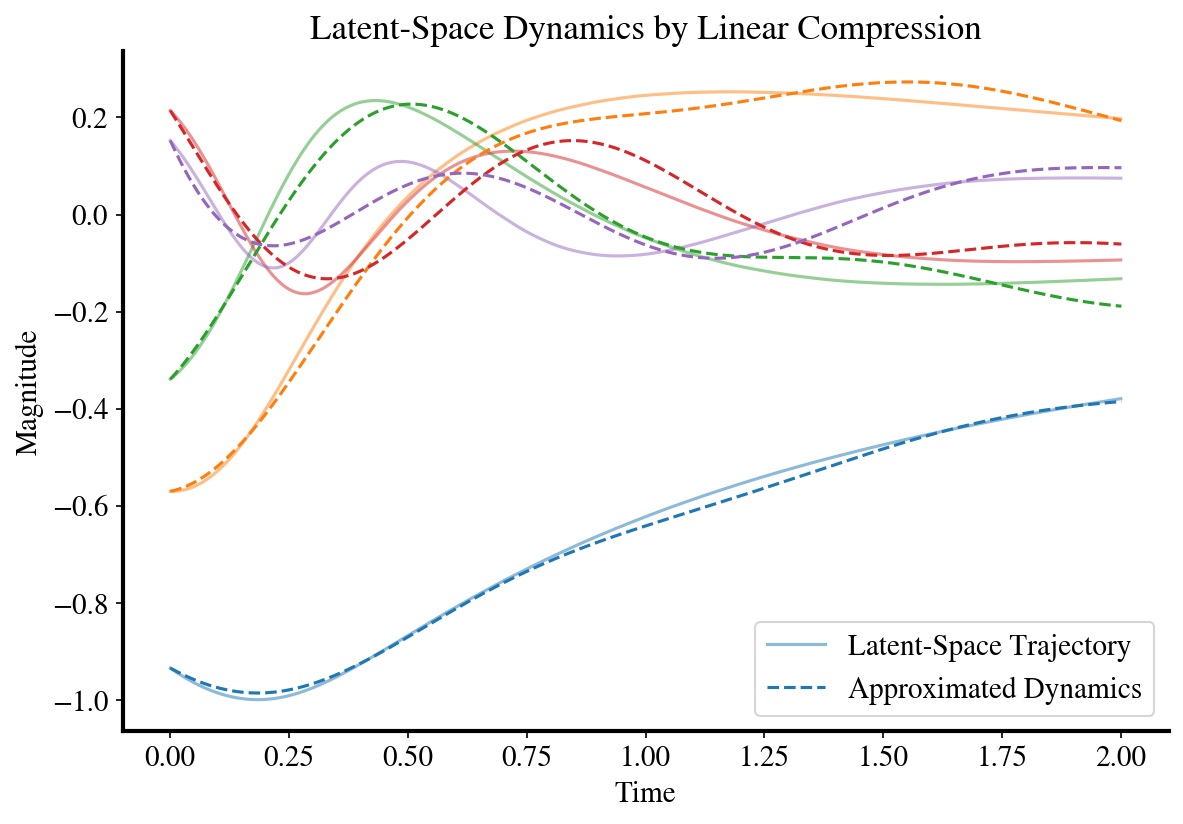

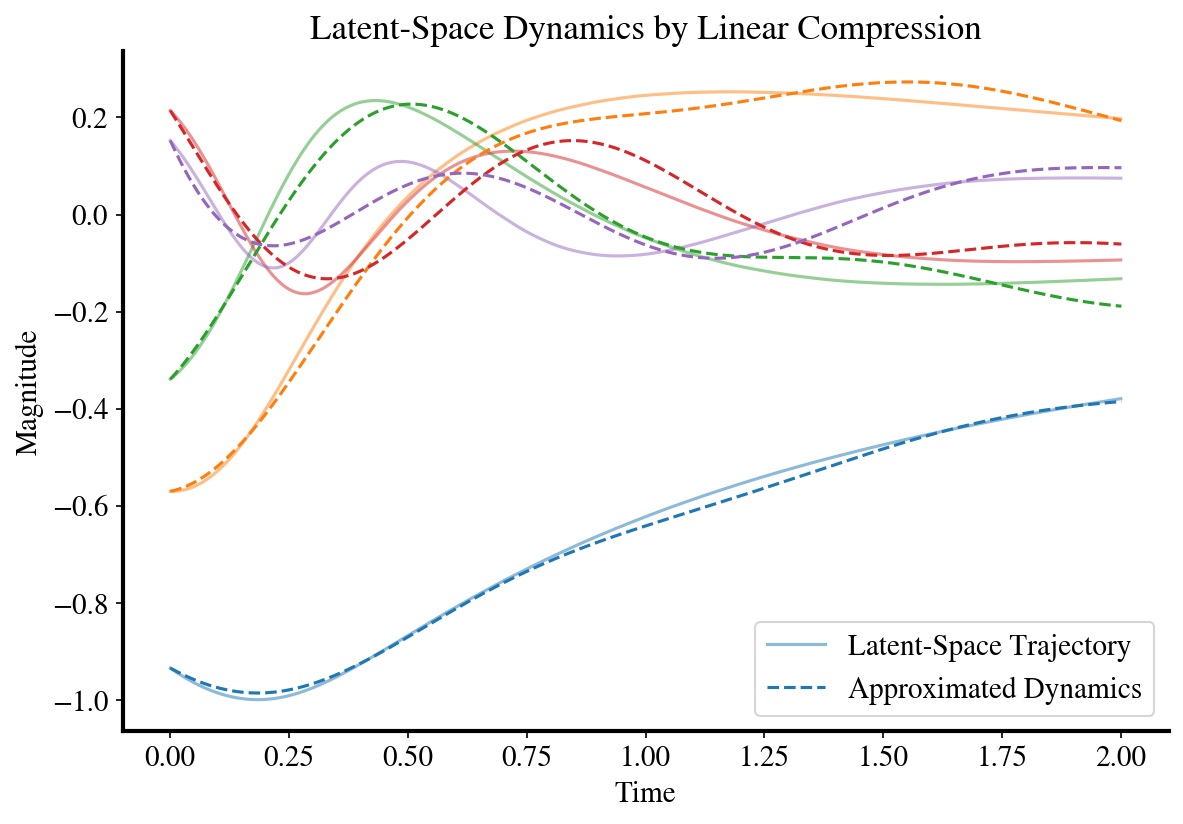

In [29]:
print('Dynamical System for U')
normal_u = np.amax(np.abs(latent_space_SS_u))
LaSDI_model_u = LaSDI(phi_u.T, phi_u)
LaSDI_model_u.train_dynamics(latent_space_SS_u, P, dt, degree = 1, include_interaction = False, normal = normal_u)
print('\nDynamical System for V')
normal_v = np.amax(np.abs(latent_space_SS_v))
LaSDI_model_v = LaSDI(phi_v.T, phi_v)
LaSDI_model_v.train_dynamics(latent_space_SS_v, P, dt, degree = 1, normal = normal_v, include_interaction = False)

## ROM Generation

In [10]:
FOM_high_Re = pickle.load(open(FOM_file,'rb'))
u_full = FOM_high_Re['u']
v_full = FOM_high_Re['v']
time_FOM = FOM_high_Re['t']

u_full = u_full.reshape(-1, nx*ny)
v_full = v_full.reshape(-1,nx*ny)

start = time.time()
FOM_recon_u = LaSDI_model_u.generate_ROM(u_full[0, free_raveled_indicies].astype('float32'), np.array([0.8,1.0]),t)
FOM_recon_v = LaSDI_model_v.generate_ROM(v_full[0, free_raveled_indicies].astype('float32'), np.array([0.8,1.0]),t)
LaSDI_time = time.time()-start

speed_up = time_FOM/LaSDI_time
max_re = np.empty(2)
test = []
for k in range(int(nt)):
    test.append(LA.norm(FOM_recon_u[k].reshape(ny-2,nx-2)-u_full[k,free_raveled_indicies].reshape(ny-2,nx-2))/LA.norm(u_full[k,free_raveled_indicies].reshape(ny-2,nx-2))*100)
max_re[0] = np.amax(test)

test = []
for k in range(int(nt)):
    test.append(LA.norm(FOM_recon_v[k].reshape(ny-2,nx-2)-v_full[k,free_raveled_indicies].reshape(ny-2,nx-2))/LA.norm(v_full[k,free_raveled_indicies].reshape(ny-2,nx-2))*100)
max_re[1] = np.amax(test) 

### Visualize Results

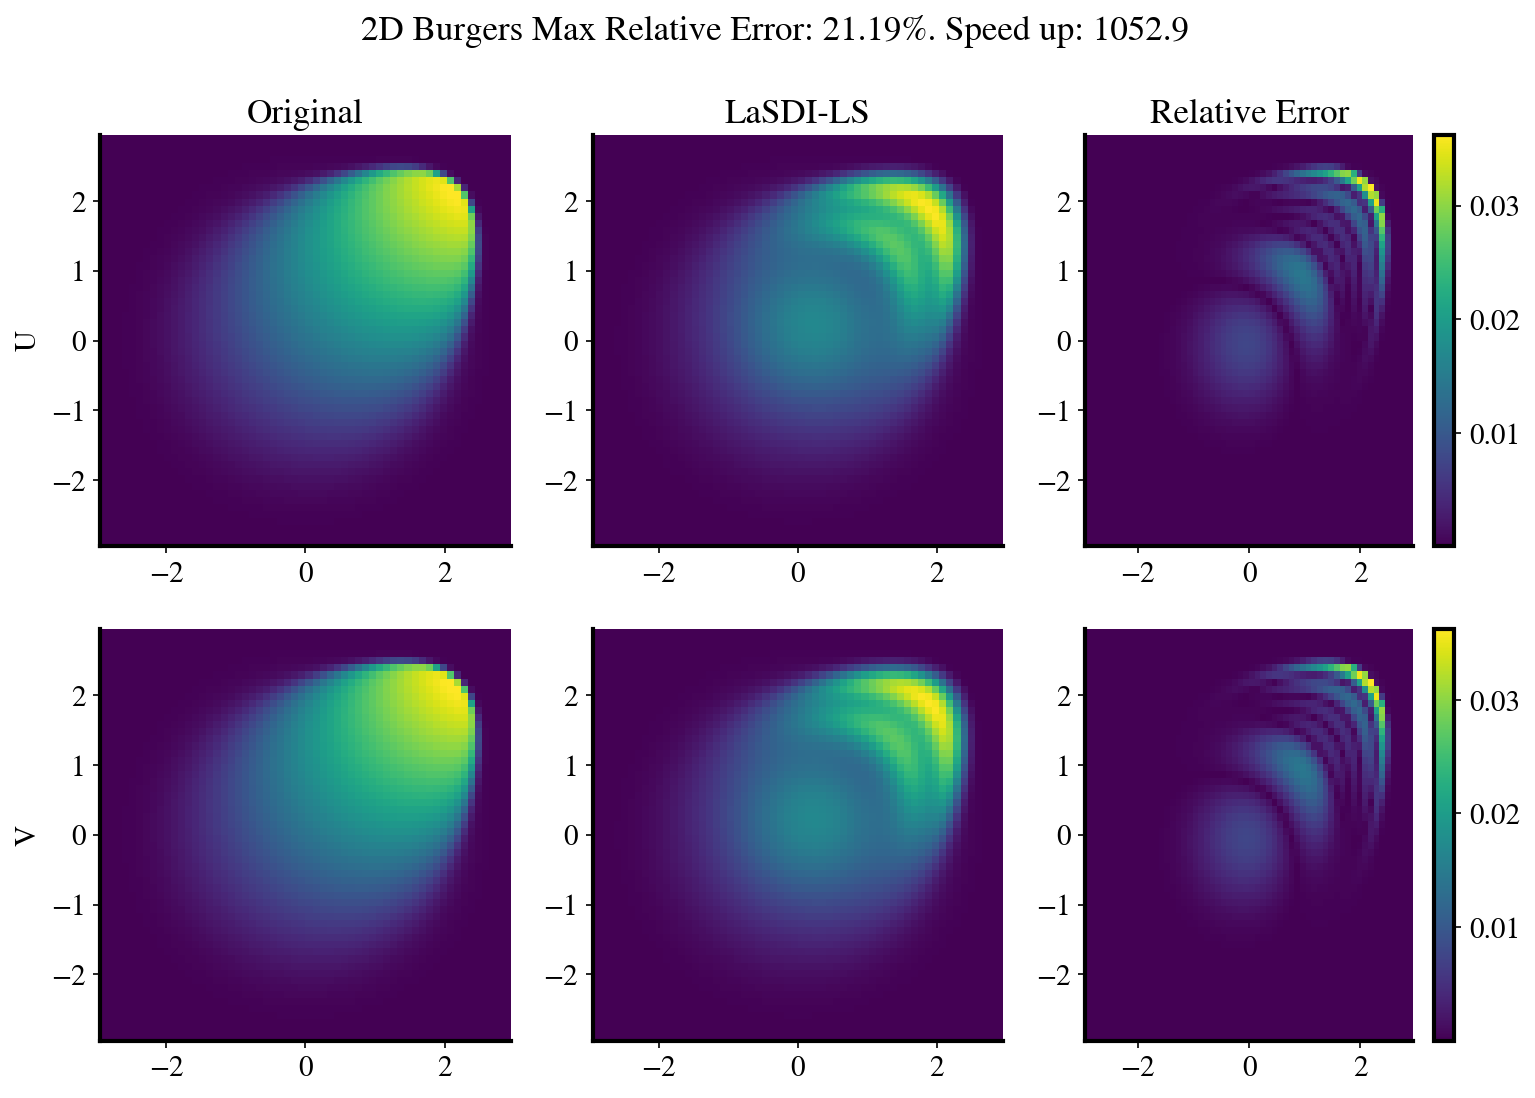

In [23]:
plt.rcParams['figure.dpi'] = 150 
plt.rcParams['font.size'] = 14
plt.rcParams['axes.linewidth'] = 2
fig = plt.figure()
ax1 = fig.add_subplot(2,3,1)
fig.set_size_inches(12,8)
z=plt.pcolormesh(x_free.reshape(nx-2,ny-2),y_free.reshape(nx-2,ny-2),u_full[k,free_raveled_indicies].reshape(nx-2,ny-2), shading = 'nearest')
fig.suptitle('2D Burgers Max Relative Error: {:.2f}%. Speed up: {:.1f}'.format(np.amax(max_re), speed_up))
ax1.set_title('Original')
ax1.set_ylabel('U')

ax2 = fig.add_subplot(2,3,2)
z=plt.pcolormesh(x_free.reshape(nx-2,ny-2),y_free.reshape(nx-2,ny-2),FOM_recon_u[k].reshape(nx-2,ny-2), shading = 'nearest')
ax2.set_title('LaSDI-LS')

ax3 = fig.add_subplot(2,3,3)
z=plt.pcolormesh(x_free.reshape(nx-2,ny-2),y_free.reshape(nx-2,ny-2),np.abs(FOM_recon_u[k].reshape(nx-2,ny-2)-u_full[k,free_raveled_indicies].reshape(nx-2,ny-2))/LA.norm(v_full[k,free_raveled_indicies].reshape(nx-2,ny-2)), shading = 'nearest')
fig.colorbar(z, ax = ax3)
ax3.set_title('Relative Error')

ax4 = fig.add_subplot(2,3,4)
z=plt.pcolormesh(x_free.reshape(nx-2,ny-2),y_free.reshape(nx-2,ny-2),v_full[k,free_raveled_indicies].reshape(nx-2,ny-2), shading = 'nearest')
# fig.colorbar(z, ax = ax4)
ax4.set_ylabel('V')

ax5 = fig.add_subplot(2,3,5)
z=plt.pcolormesh(x_free.reshape(nx-2,ny-2),y_free.reshape(nx-2,ny-2),FOM_recon_v[k].reshape(nx-2,ny-2), shading = 'nearest')

ax6 = fig.add_subplot(2,3,6)
z=plt.pcolormesh(x_free.reshape(nx-2,ny-2),y_free.reshape(nx-2,ny-2),np.abs(FOM_recon_v[k].reshape(nx-2,ny-2)-v_full[k,free_raveled_indicies].reshape(nx-2,ny-2))/LA.norm(v_full[k,free_raveled_indicies].reshape(nx-2,ny-2)), shading = 'nearest')
fig.colorbar(z, ax = ax6)

Text(0, 0.5, 'Relative Error (%)')

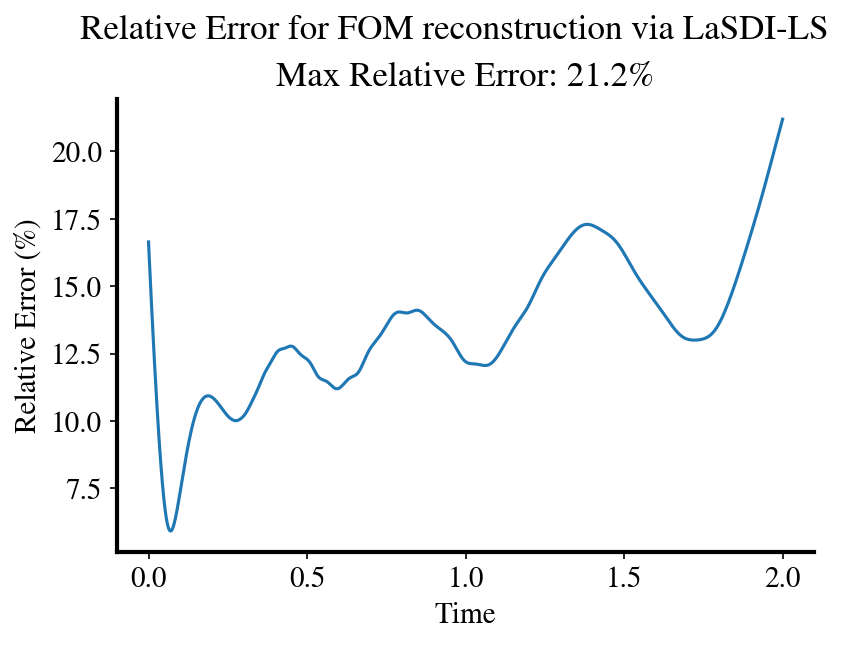

In [25]:
fig = plt.figure()
fig.suptitle('Relative Error for FOM reconstruction via LaSDI-LS', y = 1.02)
ax = plt.axes()
ax.set_title('Max Relative Error: {:.3}%'.format(np.amax(test)))
ax.plot(t, test)
ax.set_xlabel('Time')
ax.set_ylabel('Relative Error (%)')